# Load and clean Data

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA


In [14]:
df = pd.read_csv('WalmartSales.csv', parse_dates = ['Date'])

In [15]:
df.head()

,Date,Weekly_Sales
0,2010-02-05,24924.50
1,2010-02-05,50605.27
2,2010-02-05,13740.12
3,2010-02-05,39954.04
4,2010-02-05,32229.38


In [16]:
# format columns name
def format_column_names(df):
    """
    Format all column names in a DataFrame to snake_case.

    Parameters:
        df (pandas.DataFrame): DataFrame whose column names are to be formatted.

    Returns:
        pandas.DataFrame: DataFrame with column names formatted to snake_case.
    """
    formatted_columns = [col.replace(' ', '_').lower() for col in df.columns]
    df.columns = formatted_columns
    return df

In [17]:
df = format_column_names(df)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420212 entries, 0 to 420211
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   date          420212 non-null  datetime64[ns]
 1   weekly_sales  420212 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 6.4 MB


In [19]:
df = df.groupby(['date'])['weekly_sales'].sum().reset_index()

# Multiplicative Decomposition

In [51]:
from statsmodels.tsa.seasonal import seasonal_decompose
def decomposition(data, model):
    result = seasonal_decompose(data, model=model)

    # Assign decomposed components to variables
    trend = result.trend
    seasonal = result.seasonal
    residual = result.resid

    # Plotting the components
    import matplotlib.pyplot as plt

    plt.figure(figsize=(20, 20))

    plt.subplot(411)
    plt.plot(data, label='Original', marker='o', linestyle='-')
    plt.legend(loc='best')

    plt.subplot(412)
    plt.plot(trend, label='Trend', marker='o', linestyle='-')
    plt.legend(loc='best')

    plt.subplot(413)
    plt.plot(seasonal, label='Seasonal',marker='o', linestyle='-')
    plt.legend(loc='best')

    plt.subplot(414)
    plt.plot(residual, label='Residuals',marker='o', linestyle='-')
    plt.legend(loc='best')

    plt.tight_layout()
    plt.show()

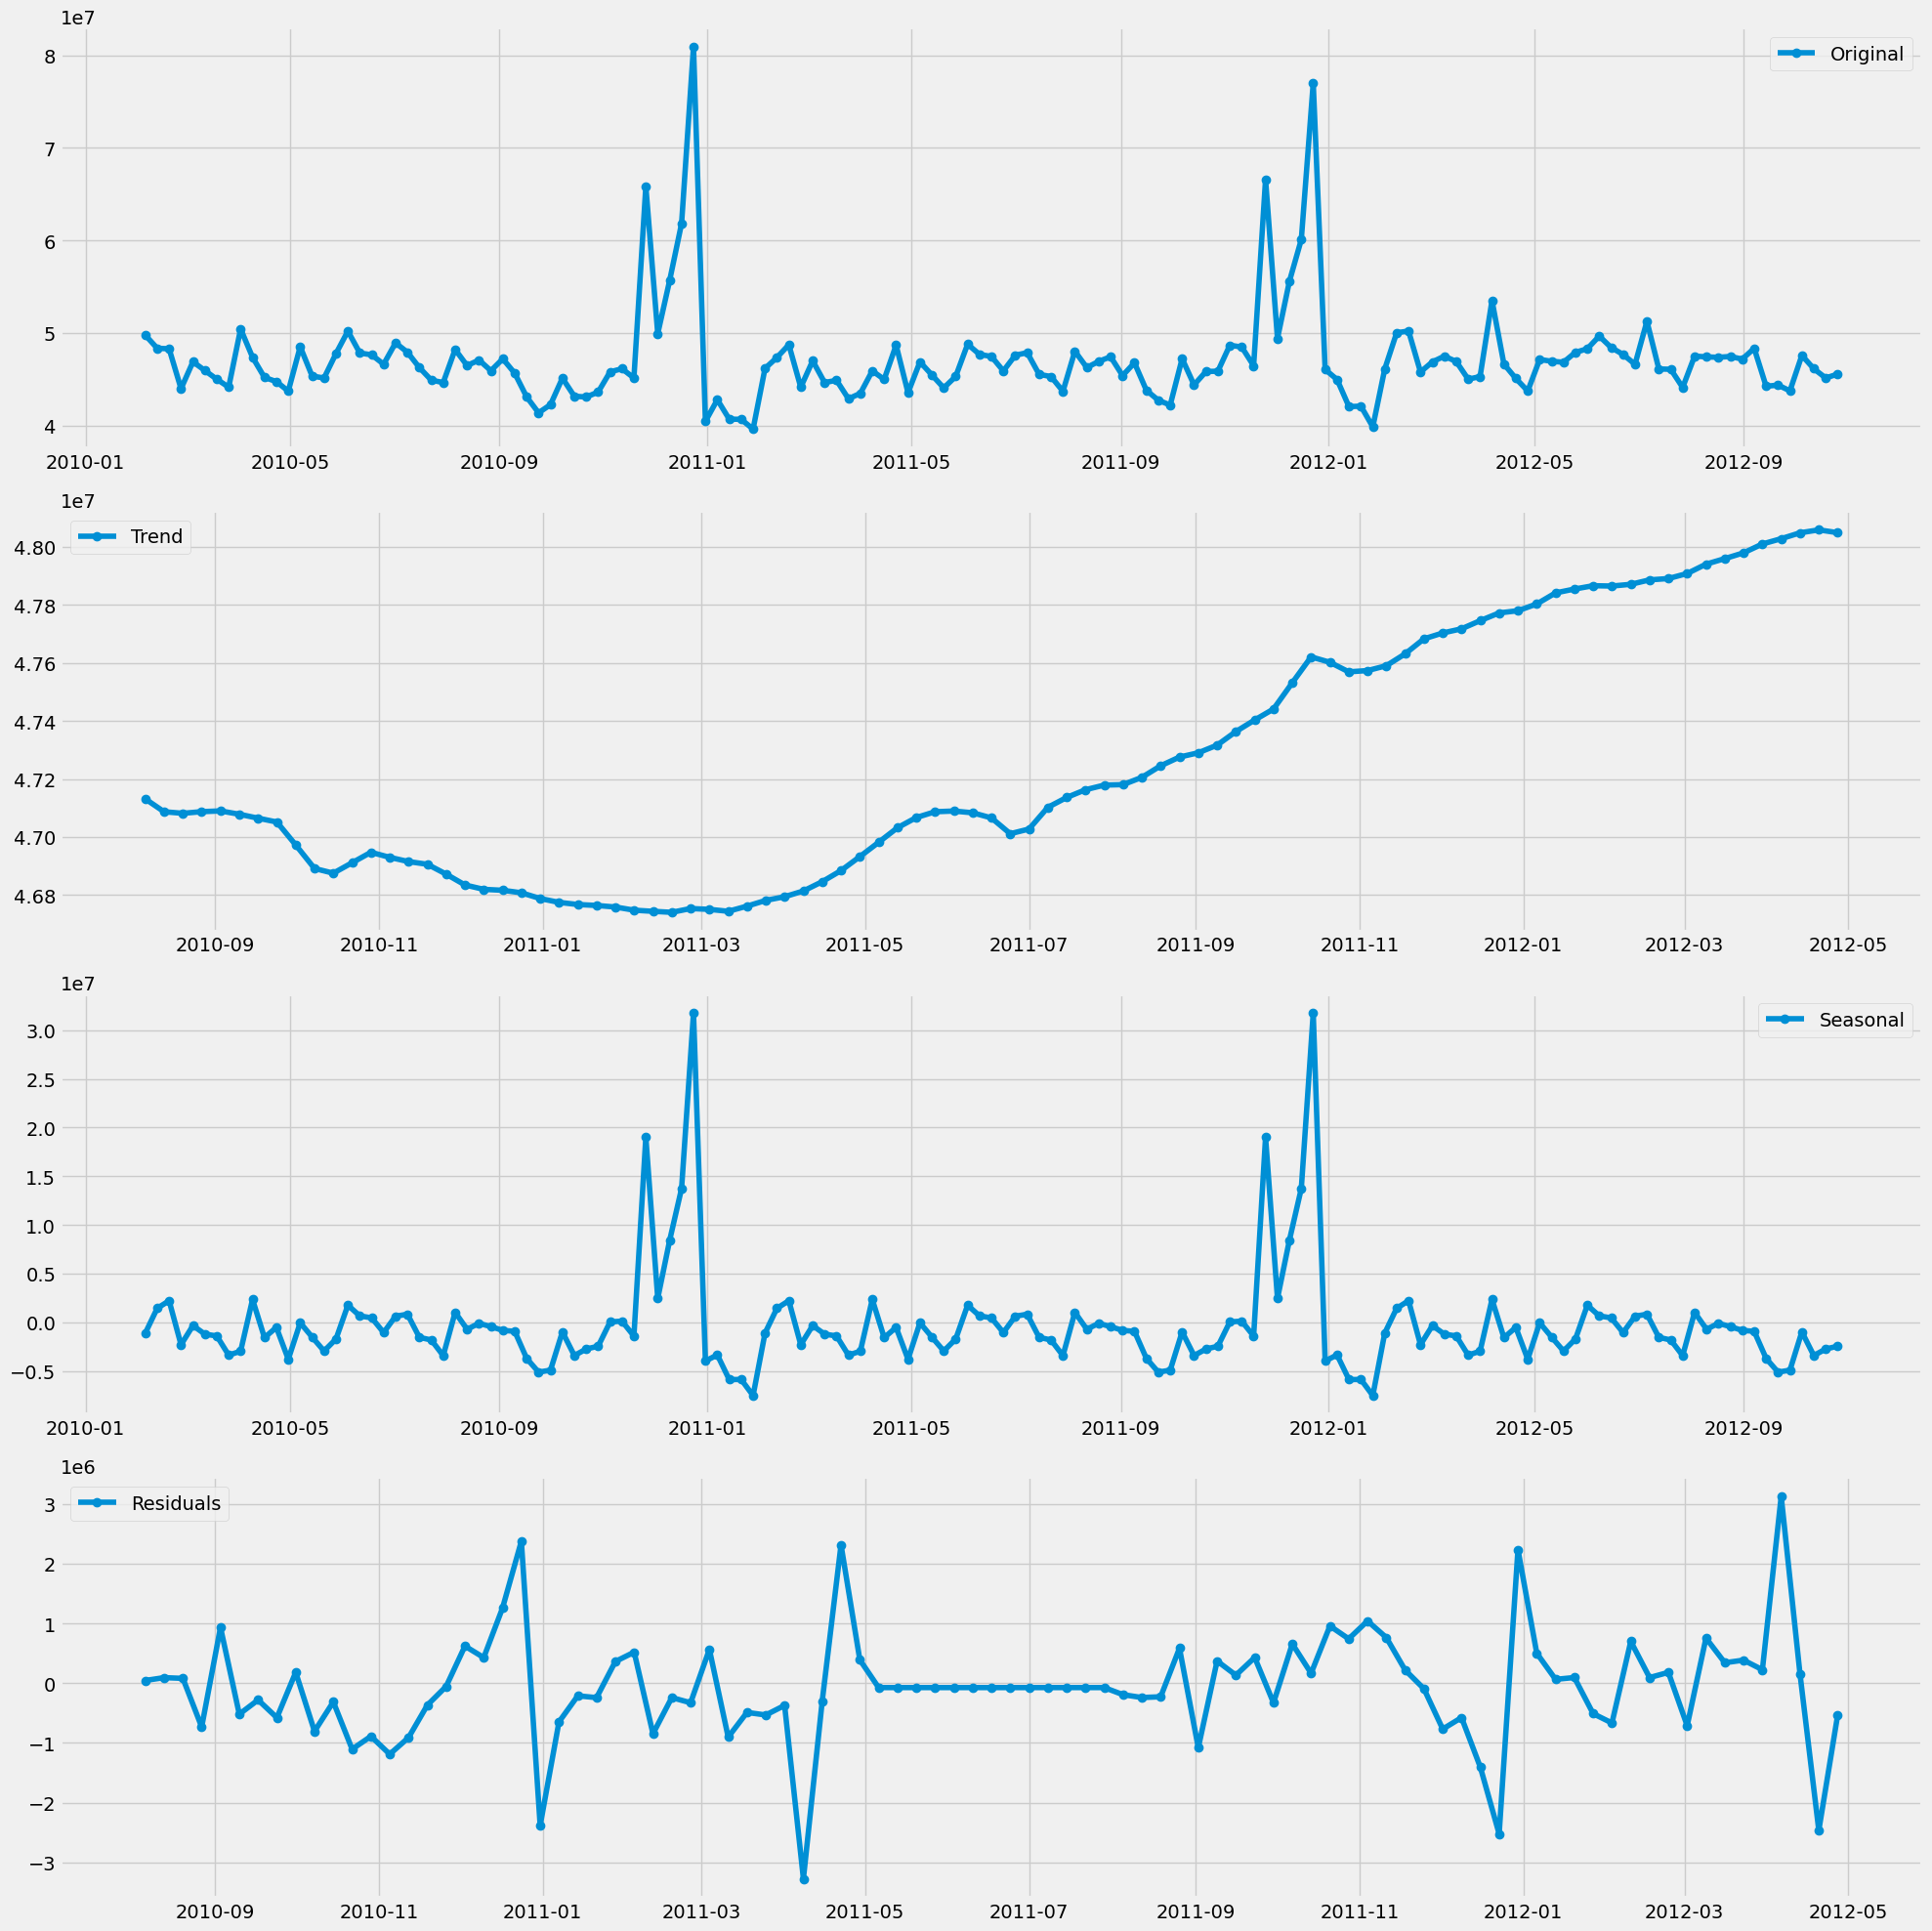

In [55]:
decomposition(df['weekly_sales'], model = 'additive')

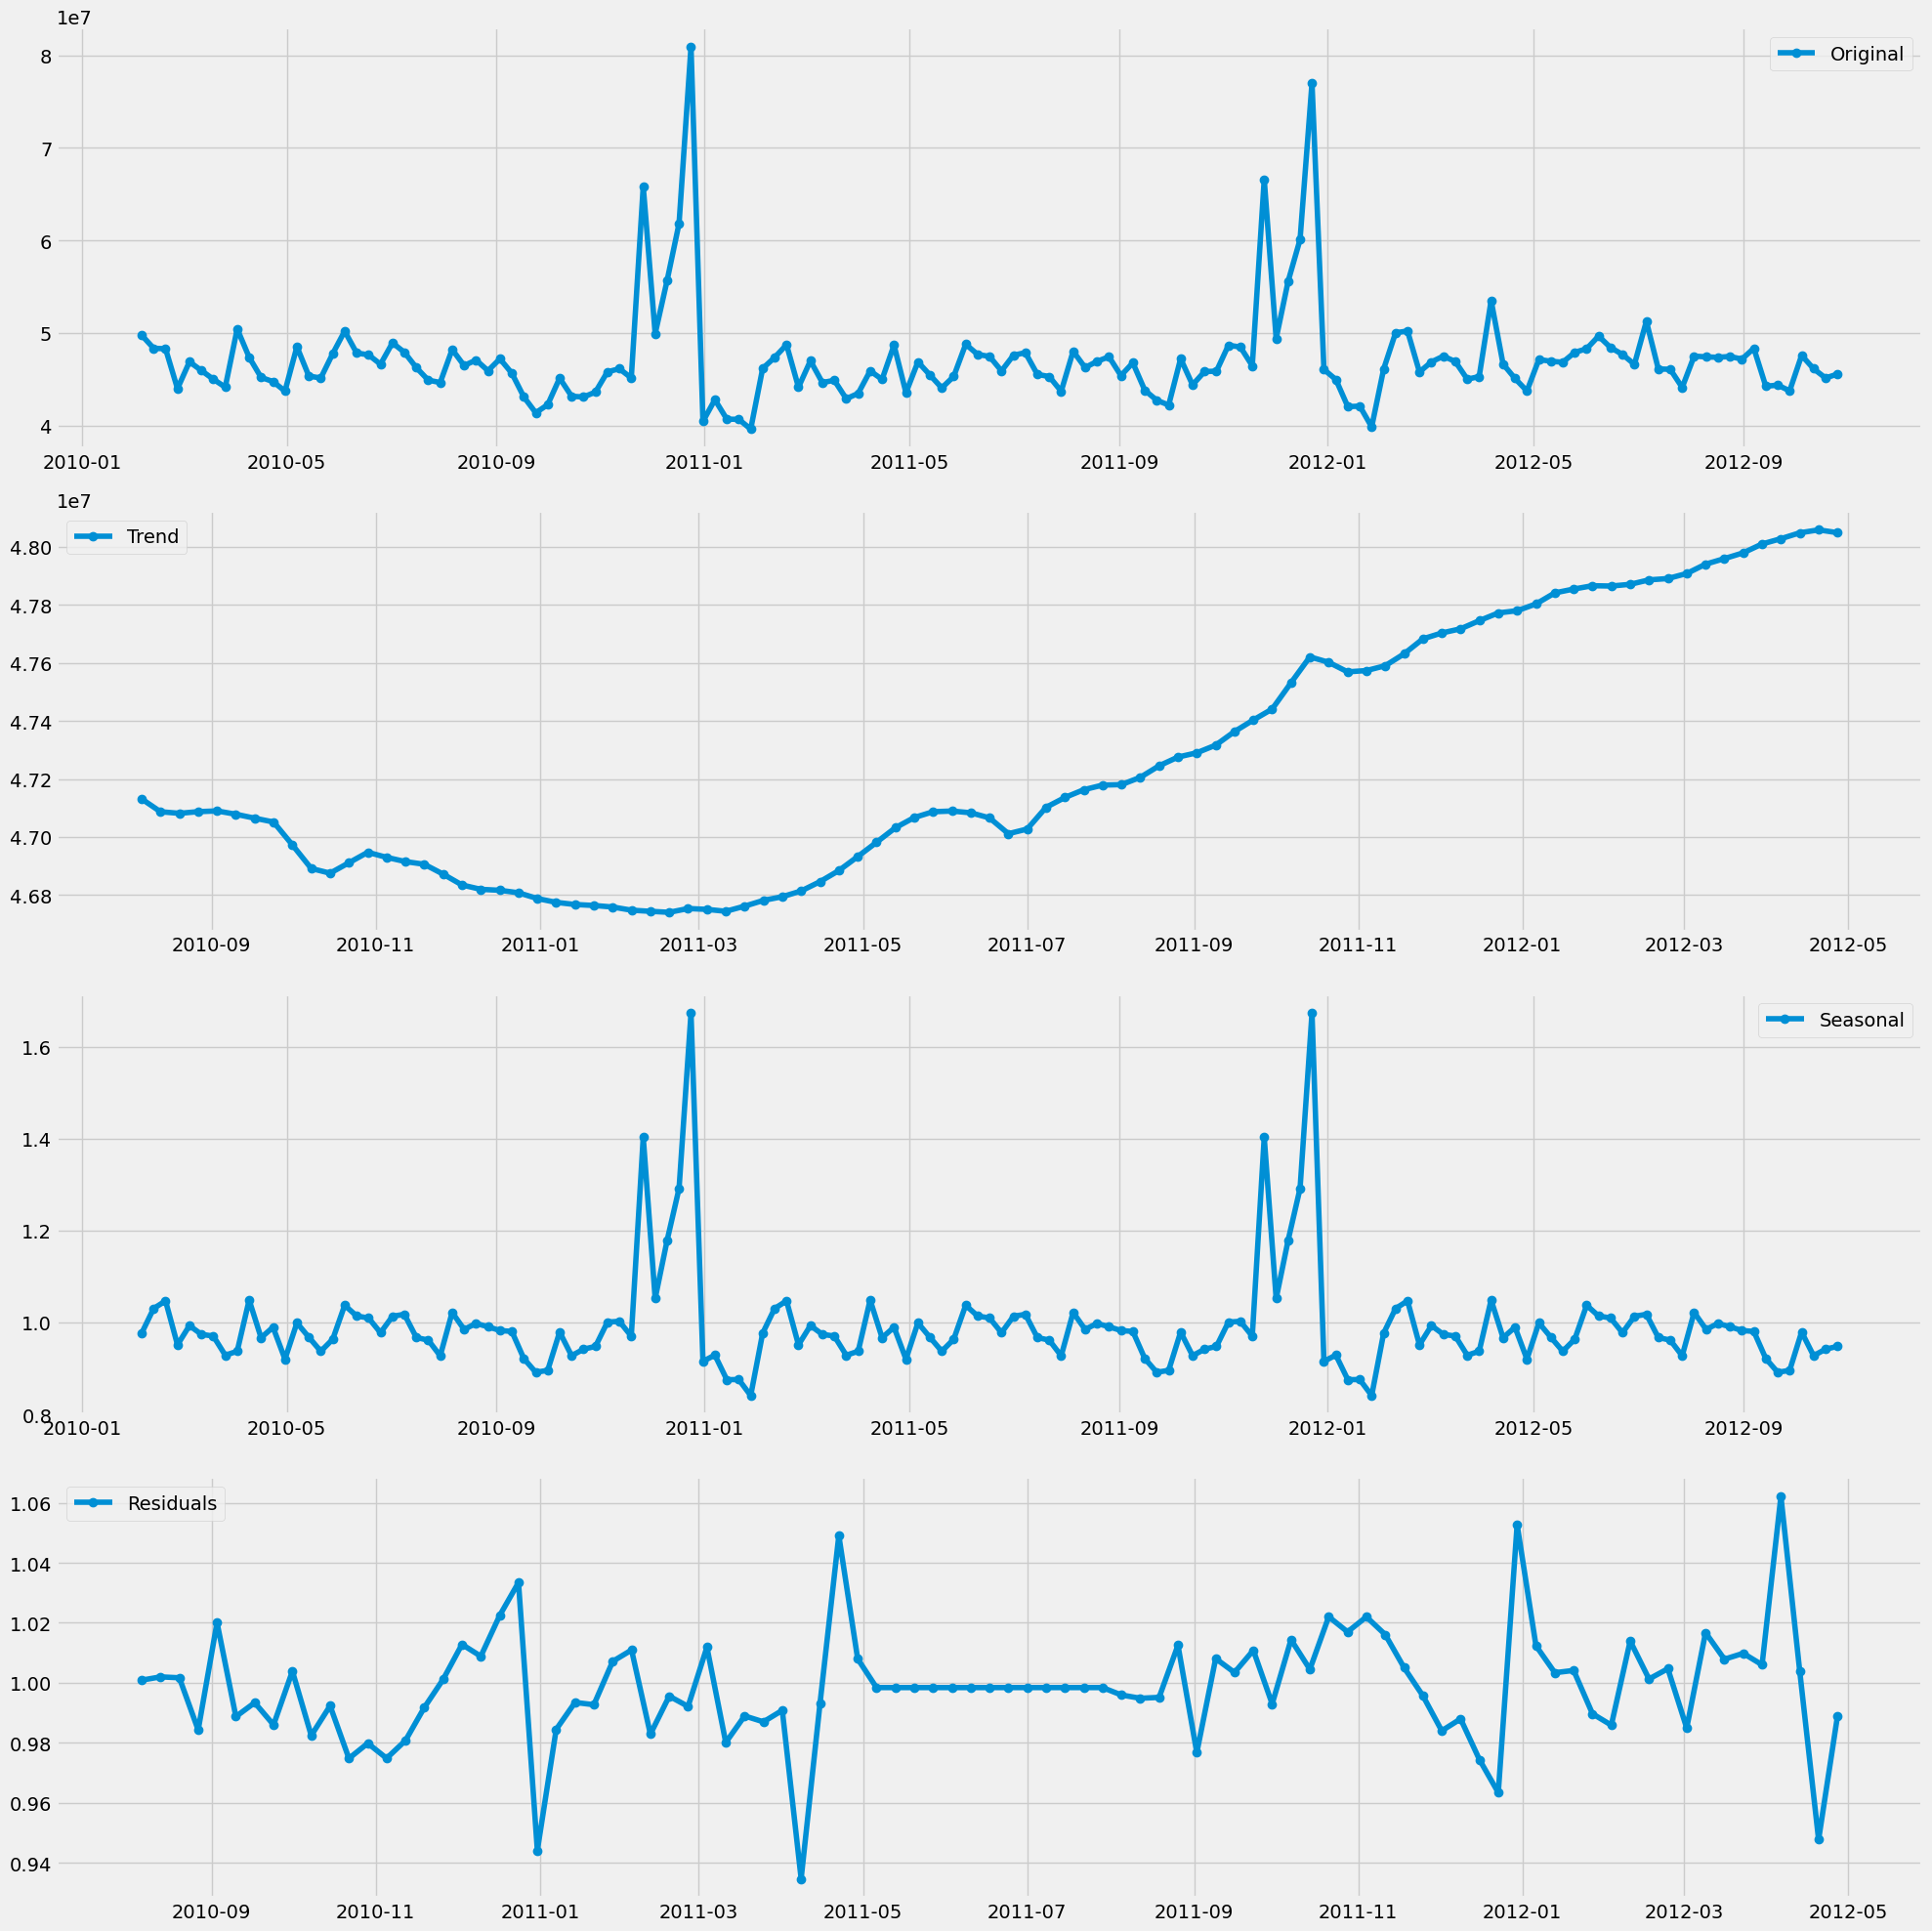

In [56]:
decomposition(df['weekly_sales'],'multiplicative')

# Check Seasonality

In [39]:
def check_seasonality(data):
    # Perform seasonal decomposition
    decomposition = sm.tsa.seasonal_decompose(data)
    
    # Plot the decomposition
    decomposition.plot()
    plt.show()
    
    # Check for seasonality based on the seasonal component
    seasonal_component = decomposition.seasonal
    seasonal_std = seasonal_component.std()
    
    # Define a threshold for detecting seasonality
    threshold = 0.05
    
    if seasonal_std > threshold:
        print("Seasonality detected in the data.")
    else:
        print("No clear seasonality detected in the data.")

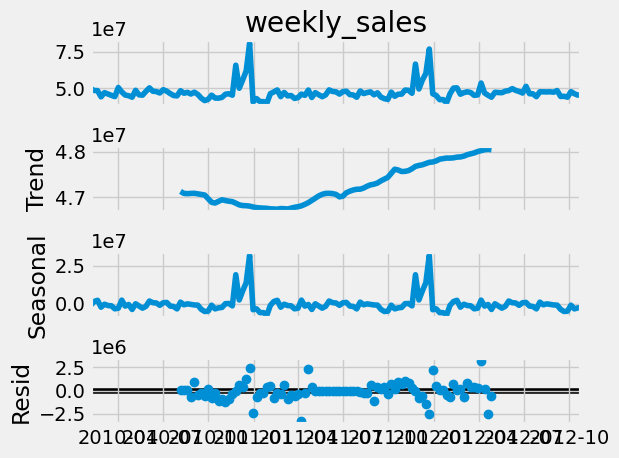

Seasonality detected in the data.


In [40]:
check_seasonality(df['weekly_sales'])

# Check Stationary

In [37]:
def check_stationary(data):
    # Perform ADF test to check stationarity
    result = adfuller(data)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')
    if result[1] < 0.05:
        print("The differentiated series is likely stationary (reject the null hypothesis)")
    else:
        print("The differentiated series is likely non-stationary (fail to reject the null hypothesis)")

In [38]:
check_stationary(df['weekly_sales'])

ADF Statistic: -5.908397717797433
p-value: 2.674606788825844e-07
Critical Values:
   1%: -3.47864788917503
   5%: -2.882721765644168
   10%: -2.578065326612056
The differentiated series is likely stationary (reject the null hypothesis)


# Plot ACF-PACF

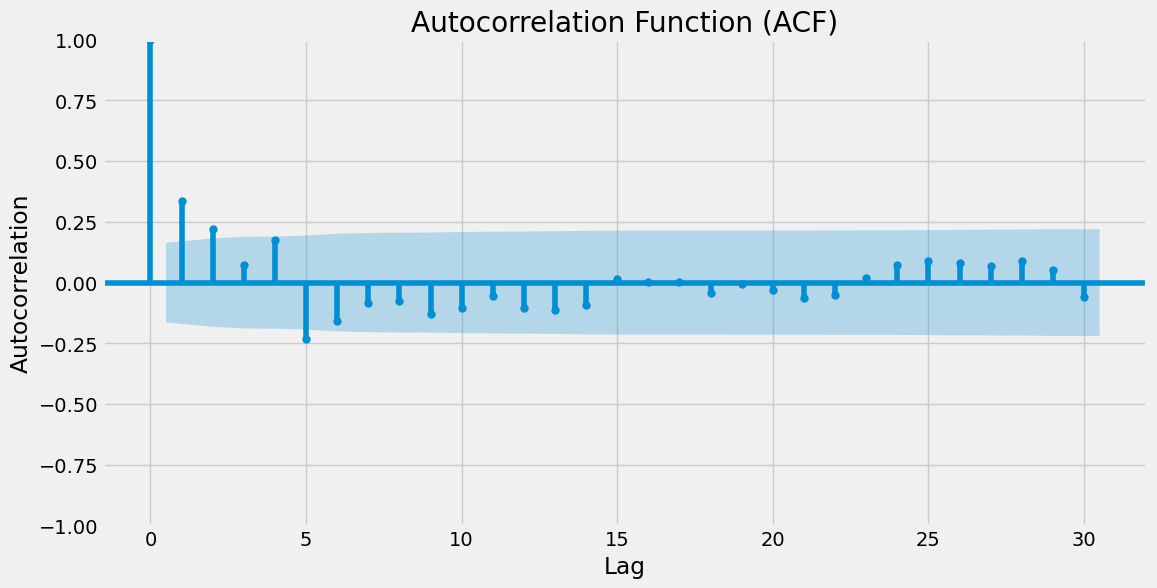

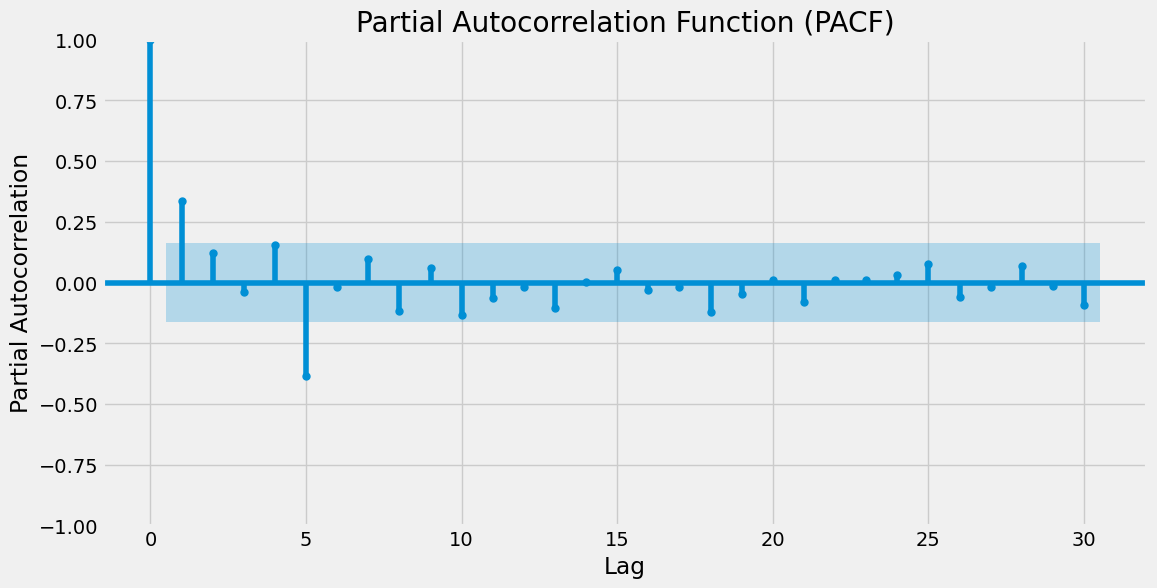

In [41]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_acf_pacf(series, lags=None):
    # Plot ACF
    plt.figure(figsize=(12, 6))
    plot_acf(series, lags=lags, ax=plt.gca())
    plt.title('Autocorrelation Function (ACF)')
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.show()
    
    # Plot PACF
    plt.figure(figsize=(12, 6))
    plot_pacf(series, lags=lags, ax=plt.gca())
    plt.title('Partial Autocorrelation Function (PACF)')
    plt.xlabel('Lag')
    plt.ylabel('Partial Autocorrelation')
    plt.show()

# Example usage:
# Assuming df is your DataFrame and 'Oil' is the column you want to model
plot_acf_pacf(df['weekly_sales'], lags=30)  # You can adjust the number of lags as needed

## ARMA

In [42]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

def fit_arima_model(data, order):
    # Fit ARIMA model
    model = ARIMA(data, order=order)
    model_fit = model.fit()
    
    # Get predicted values
    predicted_values = model_fit.predict()
    
    # Create DataFrame with original and predicted values
    df = pd.DataFrame({'Original Data': data, 'Predicted Values': predicted_values}, index=data.index)
    
    
    # Plot original data and predicted values
    df.plot()
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('ARIMA Model - Original Data vs Predicted Values')
    plt.show()
    

    # Calculate Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mean_squared_error(data[1:], predicted_values[1:]))
    print(F"Root Mean Squared Error (RMSE):, {rmse}")

    df['error_percentage'] = abs((df['Original Data'] - df['Predicted Values'])/df['Original Data']*100)
    df = df[1:]
    error_percentage_mean = df['error_percentage'].mean()
    error_percentage_std = df['error_percentage'].std()
    print(f"error_percentage_mean: {error_percentage_mean:2}")
    print(f"error_percentage_std: {error_percentage_std:2}")
    
    # Predict the next day's value
    next_day_prediction = model_fit.forecast(steps=1)[0]
    print(f"Current value for this month: {data[-1]}")
    print(f"Predicted value for the next month: {next_day_prediction}")
    
    return df

c:\Users\m.pham\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\m.pham\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\m.pham\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


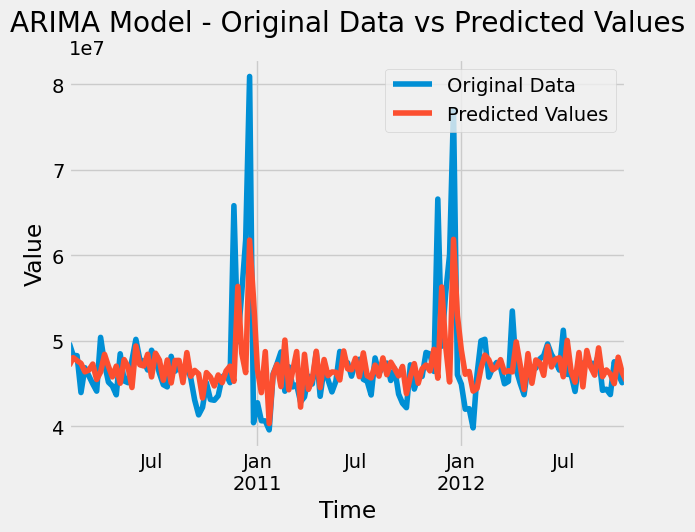

Root Mean Squared Error (RMSE):, 4670541.676590995
error_percentage_mean: 5.598550214923923
error_percentage_std: 6.257823998930346
Current value for this month: 45544379.53
Predicted value for the next month: 47922939.93080292


,Original Data,Predicted Values,error_percentage
date,,,
2010-02-12,48336800.10,4.805479e+07,0.583431
2010-02-19,48277902.33,4.770007e+07,1.196897
2010-02-26,43970440.65,4.737768e+07,7.748926
2010-03-05,46872715.16,4.638941e+07,1.031091
2010-03-12,45926841.32,4.659200e+07,1.448293
...,...,...,...
2012-09-28,43735713.56,4.613869e+07,5.494303
2012-10-05,47567053.49,4.501763e+07,5.359640
2012-10-12,46128909.98,4.810294e+07,4.279387


In [43]:
fit_arima_model(df['weekly_sales'], (3,0,3))

# SARIMA model

In [44]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [45]:
def fit_sarima_model(data, order, seasonal_order):
    # Fit SARIMA model
    model = SARIMAX(data, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False)
    
    # Get predicted values
    predicted_values = model_fit.predict()
    
    # Create DataFrame with original and predicted values
    df = pd.DataFrame({'Original Data': data, 'Predicted Values': predicted_values}, index=data.index)
    
    # Plot original data and predicted values
    df.plot()
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('SARIMA Model - Original Data vs Predicted Values')
    plt.show()
    
    # Calculate Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mean_squared_error(data[1:], predicted_values[1:]))
    print(f"Root Mean Squared Error (RMSE): {rmse}")

    # Calculate error percentage
    df['error_percentage'] = abs((df['Original Data'] - df['Predicted Values']) / df['Original Data'] * 100)
    df = df[1:]
    error_percentage_mean = df['error_percentage'].mean()
    error_percentage_std = df['error_percentage'].std()
    print(f"Error Percentage Mean: {error_percentage_mean}")
    print(f"Error Percentage Standard Deviation: {error_percentage_std}")
    
    # Predict the next value
    next_prediction = model_fit.forecast(steps=1)[0]
    print(f"Current value: {data[-1]}")
    print(f"Predicted value for the next step: {next_prediction}")

In [46]:
fit_sarima_model(df['weekly_sales'], (3,0,3), )

TypeError: fit_sarima_model() missing 1 required positional argument: 'seasonal_order'